# Overview
This notebook is a step by step to calculate the degrees from semi-circular trajectory data

## Steps
* grab the first point in the trajectory data (960, 707)
* reverse the datapoints
* grab the last point in the trajectory data and loop through every trial
* convert the origin (960, 707) to (0,0) - which will give you an updated coordinate
* using this updated coordinate, transfor it to polar coordinates, which will give you the degree of the data point

--

* count number of data points that fall in the origin
* clean data that is within r of 150
* if there is negative theta, convert it to 0 

--

* load data
* add subject number
* extract relevant columns
* concat data, axis 0
* average degree

## libraries

In [1]:

%matplotlib inline

import pandas as pd
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import loggamma
from scipy.stats import johnsonsu
from scipy.optimize import fmin
from scipy.stats import beta
from scipy.stats import frechet_l
from scipy.special import gamma as gammaf
import warnings
import scipy.stats as st
import statsmodels as sm
import seaborn as sns
import glob

## seaborn style

In [2]:
large = 40; med = 22; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': 30,
          'xtick.labelsize': 14,
          'ytick.labelsize': med,
          #'xtick.direction': ,
          'figure.titlesize': large}
plt.rcParams.update(params)

plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

## function - cartesian to polar coordinates

In [3]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

In [4]:
origin_x = 960
origin_y = 707

# load pain

In [53]:
sublist = [3,4] 
thermode = ['pain'] #, 30]
main_dir = '/Users/h/Documents/projects_local/social_influence_analysis/dartmouth/beh_withcoord'

df = pd.DataFrame()
p_result = pd.DataFrame()

for ind,sub in enumerate(sublist):
    loadfilename =  glob.glob(os.path.join(main_dir ,  'sub-*', 
                                  '*_task-pain_meta_beh.csv'))
for file in loadfilename:
    df = pd.read_csv(file)
#     df['src_subject_id'] = sub
    p_result = pd.concat([p_result, df], axis = 0, sort = True)

In [54]:
loadfilename

['/Users/h/Documents/projects_local/social_influence_analysis/dartmouth/beh_withcoord/sub-0003/sub-0003_ses-01_task-pain_meta_beh.csv',
 '/Users/h/Documents/projects_local/social_influence_analysis/dartmouth/beh_withcoord/sub-0004/sub-0004_ses-01_task-pain_meta_beh.csv']

In [55]:

print(np.unique(p_result['src_subject_id']))


[3 4]


In [56]:
# step 3 - subtract mid point (psychtoolbox) ________________________________________________________________________

#p_result['new_expect_coord_x'] = (p_result['expect_ptb_coord_x'] - origin_x)
#p_result['new_expect_coord_y'] = (p_result['expect_ptb_coord_y'] - origin_y)
p_result['new_actual_coord_x'] = (p_result['actual_ptb_coord_x'] - origin_x)
p_result['new_actual_coord_y'] = (p_result['actual_ptb_coord_y'] - origin_y)

#p_result['expect_r'], p_result['expect_theta'] = cart2pol(p_result['new_expect_coord_x'], p_result['new_expect_coord_y'])
p_result['actual_r'], p_result['actual_theta'] = cart2pol(p_result['new_actual_coord_x'], p_result['new_actual_coord_y'])


In [57]:
# make sure to extract pi, otherwise, the thetas are flipped _____________________________________________________________________
#p_result['expect_theta_pi'] = p_result['expect_theta']-np.pi
p_result['actual_theta_pi'] = p_result['actual_theta']-np.pi
#p_result['expect_theta_degree'] = p_result['expect_theta_pi']*180/np.pi
p_result['actual_theta_degree'] = p_result['actual_theta_pi']*180/np.pi


In [58]:
p_result.head()

ISI01_biopac  ISI01_duration   ISI01_onset  ISI02_biopac  ISI02_duration  \
0  1.611769e+09        1.388991  1.611769e+09  1.611769e+09        4.536944   
1  1.611769e+09        0.778355  1.611769e+09  1.611769e+09        1.059877   
2  1.611769e+09        1.085627  1.611769e+09  1.611769e+09        2.567039   
3  1.611769e+09        2.092753  1.611769e+09  1.611769e+09        9.373788   
4  1.611770e+09        1.380569  1.611770e+09  1.611770e+09        1.361862   

    ISI02_onset  ISI03_biopac  ISI03_duration   ISI03_onset    ITI_biopac  \
0  1.611769e+09  1.611769e+09        2.381851  1.611769e+09  1.611769e+09   
1  1.611769e+09  1.611769e+09        4.189426  1.611769e+09  1.611769e+09   
2  1.611769e+09  1.611769e+09        2.596023  1.611769e+09  1.611769e+09   
3  1.611769e+09  1.611770e+09        2.283539  1.611770e+09  1.611769e+09   
4  1.611770e+09  1.611770e+09        2.291296  1.611770e+09  1.611770e+09   

   ...  param_task_name  param_trigger_onset  session_id  src_subject_id  \
0  ...             pain         1.611769e+09           1               3   
1  ...             pain         1.611769e+09           1               3   
2  ...             pain         1.611769e+09           1               3   
3  ...             pain         1.611769e+09           1               3   
4  ...             pain         1.611769e+09           1               3   

   new_actual_coord_x  new_actual_coord_y    actual_r  actual_theta  \
0                -212                -130  248.684539     -2.591518   
1                 -94                -218  237.402612     -1.977900   
2                -234                 -88  250.000000     -2.781886   
3                 -97                -225  245.018367     -1.977832   
4                -248                 -13  248.340492     -3.089221   

  actual_theta_pi  actual_theta_degree  
0       -5.733111          -328.483060  
1       -5.119493          -293.325351  
2       -5.923478          -339.390307  
3       -5.119424          -293.321411  
4       -6.230814          -356.999339  

[5 rows x 69 columns]

In [59]:
np.histogram(p_result['actual_r'])

(array([ 2,  0,  0,  0,  0,  0,  4,  4, 20, 18]),
 array([237.40261161, 238.66235045, 239.92208929, 241.18182813,
        242.44156697, 243.70130581, 244.96104464, 246.22078348,
        247.48052232, 248.74026116, 250.        ]))

## filter actual rating

In [60]:
p_actual_filter = p_result.loc[(p_result['actual_r']>=150) & (p_result['event04_actual_responseonset'] != "NA") ]


## actual rating - cue

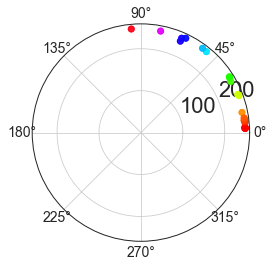

In [61]:
# Compute areas and colors
p_result = p_actual_filter
colors = p_result['actual_theta_pi']

fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(p_result['actual_theta_pi'], p_result['actual_r'], c=colors, cmap='hsv', alpha=0.75)


### plot raw form

Text(0.5, 0.8, 'Thermode ratings\n on a semi-circular scale')

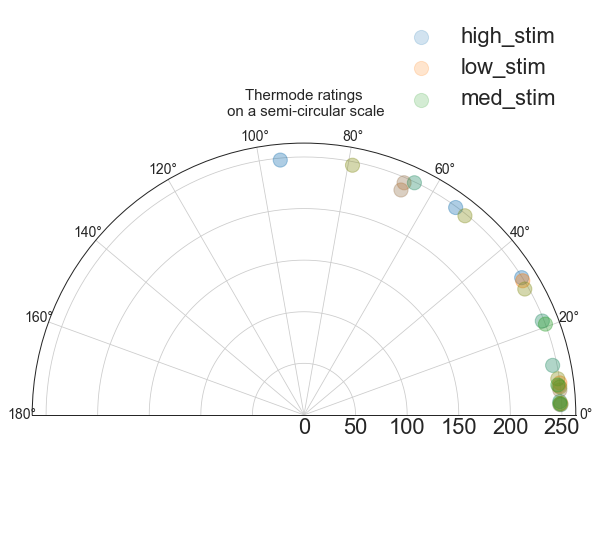

In [62]:


# area = 200 * result['expect_newr']**2
p_result['newr'] = np.ones(p_result.actual_r.shape)
area = 200 * p_result['newr']**2
groups = p_result.groupby('param_stimulus_type')
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='polar')
ax.set_thetamin(0)
ax.set_thetamax(180)

for name, group in groups:
    ax.scatter(group.actual_theta_pi, group.actual_r,label=name, alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
ax.legend()

figure_title = "Thermode ratings\n on a semi-circular scale"
plt.text(0.5, 0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

### plot by rotation degrees

Text(0.5, 0.8, 'Pain task\n rating on semi-circular scale per degree')

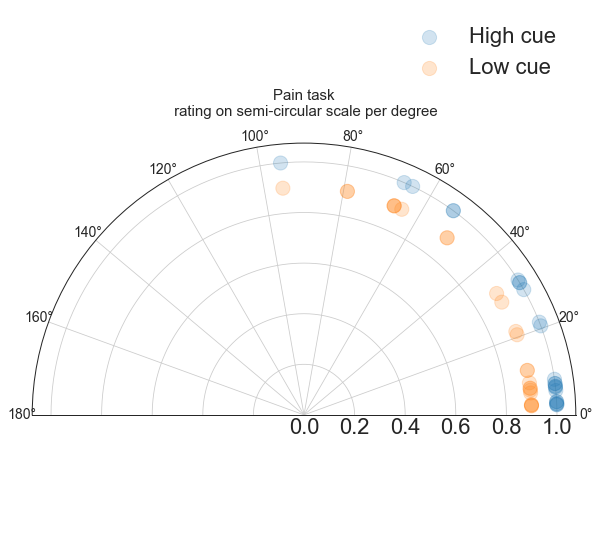

In [63]:
# Compute areas and colors

colors = p_result['actual_theta_pi']
p_result['newr'] = np.ones(p_result.actual_r.shape)

area = 200 * p_result['newr']**2


ca_group_low = p_result.loc[p_result['param_cue_type'] =='low_cue']
ca_group_high = p_result.loc[(p_result['param_cue_type']== 'high_cue')] #| (p_result['param_cue_type']== 10)]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='polar')
ax.set_thetamin(0)
ax.set_thetamax(180)
p100 = ax.scatter(ca_group_high.actual_theta_pi, np.ones(ca_group_high.actual_r.shape),label='High cue', alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
p50 = ax.scatter(ca_group_low.actual_theta_pi, np.ones(ca_group_low.actual_r.shape)*0.9,label='Low cue', alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
figure_title = "Pain task\n rating on semi-circular scale per degree"
plt.text(0.5, 0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

### participant mean

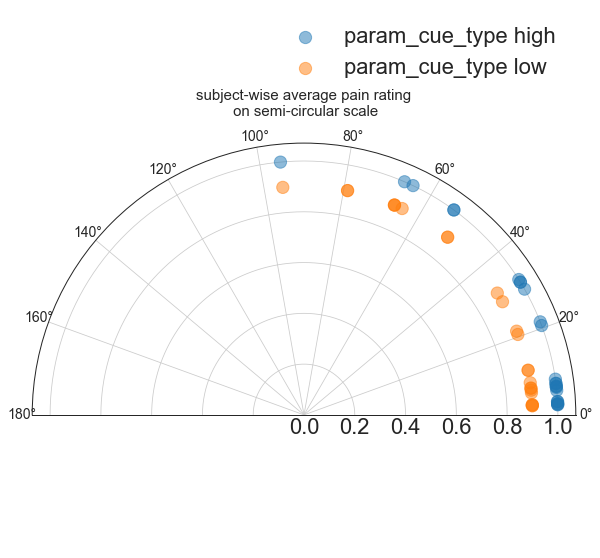

In [64]:
c_group_mean = p_result.groupby(['param_cue_type','src_subject_id']).mean().reset_index()
colors = c_group_mean['actual_theta_pi']
c_group_mean['newr'] = np.ones(c_group_mean.actual_r.shape)
area = 150 * c_group_mean['newr']**2

c_group_mean_low = p_result.loc[p_result['param_cue_type'] =='low_cue']
c_group_mean_high = p_result.loc[(p_result['param_cue_type']== 'high_cue')] 
fig = plt.figure(figsize=(10, 10));ax = fig.add_subplot(projection='polar');ax.set_thetamin(0);ax.set_thetamax(180)
figure_title = "subject-wise average pain rating\n on semi-circular scale"
plt.text(0.5,0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

chigh = ax.scatter(c_group_mean_high.actual_theta_pi, np.ones(c_group_mean_high.newr.shape),label='param_cue_type high', alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
clow = ax.scatter(c_group_mean_low.actual_theta_pi, np.ones(c_group_mean_low.newr.shape)*0.9,label='param_cue_type low', alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 

# p150 = ax.scatter(group_mean_150.theta, np.ones(group_mean_150.newr.shape)*1.1,label=150, alpha=0.60, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
ax.legend()

## actual rating - temperature

### raw form

Text(0.5, 0.8, 'Cognitive task\n rating on semi-circular scale')

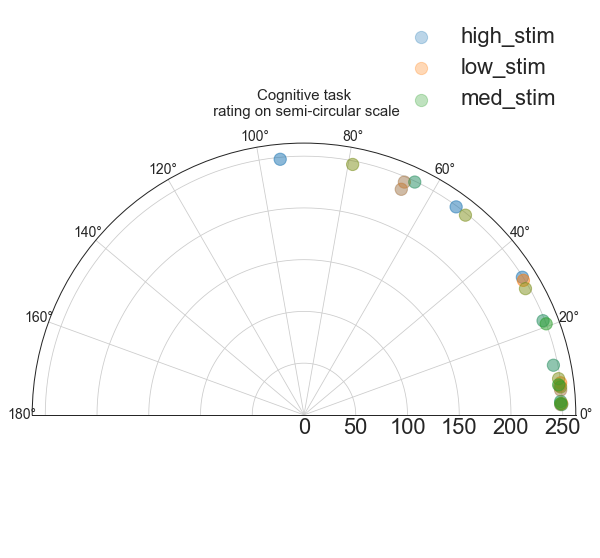

In [65]:
groups = p_result.groupby('param_stimulus_type')
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='polar')
ax.set_thetamin(0)
ax.set_thetamax(180)

for name, group in groups:
    ax.scatter(group.actual_theta_pi, group.actual_r,label=name, alpha=0.30, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
ax.legend()

figure_title = "Cognitive task\n rating on semi-circular scale"
plt.text(0.5, 0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

### rotation degrees - ignore r

Text(0.5, 0.8, "all subject's rating on semi-circular scale per celcius")

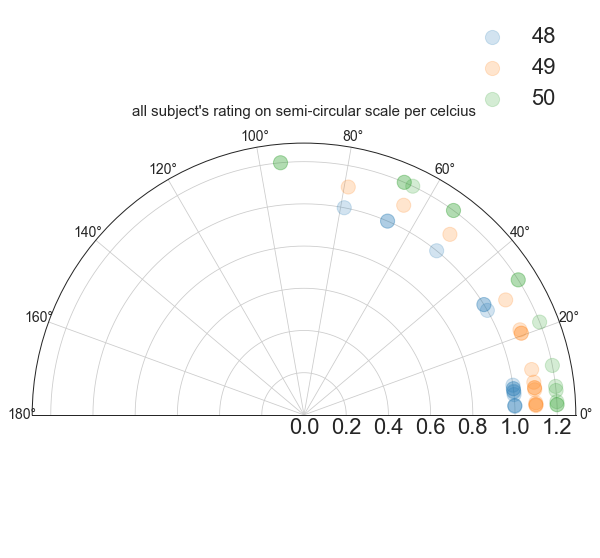

In [66]:
# Compute areas and colors
colors = p_result['actual_theta_pi']
p_result['newr'] = np.ones(p_result.actual_r.shape)

area = 200 * p_result['newr']**2

# groups = c_result.groupby('administer')
group45 = p_result[p_result['param_stimulus_type'] =='low_stim']
group46 = p_result[p_result['param_stimulus_type'] =='med_stim']
group47 = p_result[p_result['param_stimulus_type'] =='high_stim']


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='polar')
ax.set_thetamin(0)
ax.set_thetamax(180)
p45 = ax.scatter(group45.actual_theta_pi, np.ones(group45.actual_r.shape)*1.0,label=48, alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
p46 = ax.scatter(group46.actual_theta_pi, np.ones(group46.actual_r.shape)*1.1,label=49, alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
p47 = ax.scatter(group47.actual_theta_pi, np.ones(group47.actual_r.shape)*1.2,label=50, alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
# p48 = ax.scatter(group48.actual_theta_pi, np.ones(group48.actual_r.shape)*1.3,label=48, alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
# p49 = ax.scatter(group49.actual_theta_pi, np.ones(group49.actual_r.shape)*1.4,label=49, alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
# p50 = ax.scatter(group50.actual_theta_pi, np.ones(group50.actual_r.shape)*1.5,label=50, alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
figure_title = "all subject's rating on semi-circular scale per celcius"
plt.text(0.5, 0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

### subject-wise mean

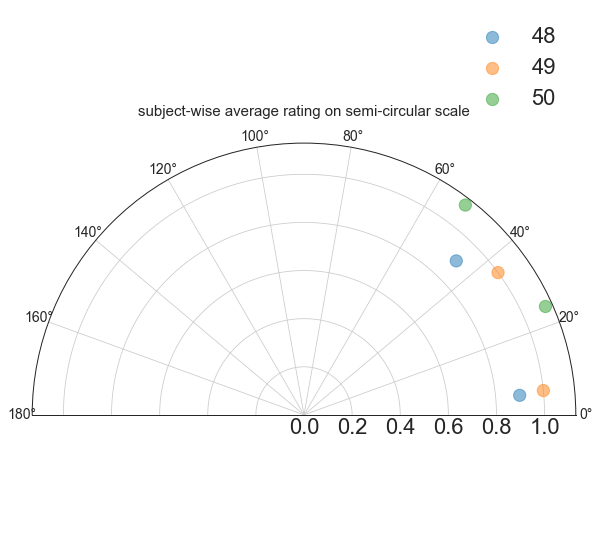

In [84]:
p_group_mean = p_result.groupby(['param_stimulus_type','src_subject_id']).mean().reset_index()
colors = p_group_mean['actual_theta_pi']
p_group_mean['newr'] = np.ones(p_group_mean.actual_r.shape)
# area = 200 * p_result['newr']**2
area = 150 * p_group_mean['newr']**2


# actual_group_mean_50 = c_group_mean[c_group_mean['p5_administer_type'] ==50]
# actual_group_mean_100 = c_group_mean[c_group_mean['p5_administer_type'] ==100]
# actual_group_mean_150 = c_group_mean[c_group_mean['p5_administer_type'] ==150]


group_mean_45 = p_group_mean[p_group_mean['param_stimulus_type'] =='low_stim']
group_mean_46 = p_group_mean[p_group_mean['param_stimulus_type'] =='med_stim']
group_mean_47 = p_group_mean[p_group_mean['param_stimulus_type'] =='high_stim']


fig = plt.figure(figsize=(10, 10));ax = fig.add_subplot(projection='polar');
ax.set_thetamin(0);ax.set_thetamax(180)

figure_title = "subject-wise average rating on semi-circular scale"
plt.text(0.5,0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

mp45 = ax.scatter(group_mean_45.actual_theta_pi, np.ones(group_mean_45.newr.shape)*0.9,label=48, alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
mp46 = ax.scatter(group_mean_46.actual_theta_pi, np.ones(group_mean_46.newr.shape)*1.0,label=49, alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
mp47 = ax.scatter(group_mean_47.actual_theta_pi, np.ones(group_mean_47.newr.shape)*1.1,label=50, alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
# mp48 = ax.scatter(group_mean_48.actual_theta_pi, np.ones(group_mean_48.newr.shape)*1.2,label=50, alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
# mp49 = ax.scatter(group_mean_49.actual_theta_pi, np.ones(group_mean_49.newr.shape)*1.3,label=50, alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
# mp50 = ax.scatter(group_mean_50.actual_theta_pi, np.ones(group_mean_50.newr.shape)*1.4,label=50, alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 

ax.legend()

In [119]:
np.ones(group_mean_45.newr.shape)*0.9

array([0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9])

## split subgroup

In [71]:
grouped = p_result.groupby('plateau')
rowlength = grouped.ngroups/2                         # fix up if odd number of groups
fig, axs = plt.subplots(2, 1, subplot_kw=dict(projection='polar'))
axs.set_thetamin(0);axs.set_thetamax(180)
# plt.subplots(figsize=(9,4), 
#                         nrows=1, ncols=rowlength, subplot_kw=dict(polar=True))    # fix as above
#                         #gridspec_kw=dict(hspace=0.4),
#                          # Much control of gridspec

# c_group_mean = c_result.groupby(['temperature','src_subject_id']).mean().reset_index()
targets = zip(grouped.groups.keys(), axs.flatten())


SyntaxError: positional argument follows keyword argument (<ipython-input-71-91472ece9286>, line 3)

# merge Plataues (if 5 for longer plateaus)

In [11]:
p_result['merge_plateau'] = p_result['plateau']
p_result['merge_plateau'] = p_result['merge_plateau'].replace([5],10)

https://stackoverflow.com/questions/43875258/how-to-change-the-positions-of-subplot-titles-and-axis-labels-in-seaborn-facetgr

/Users/h/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


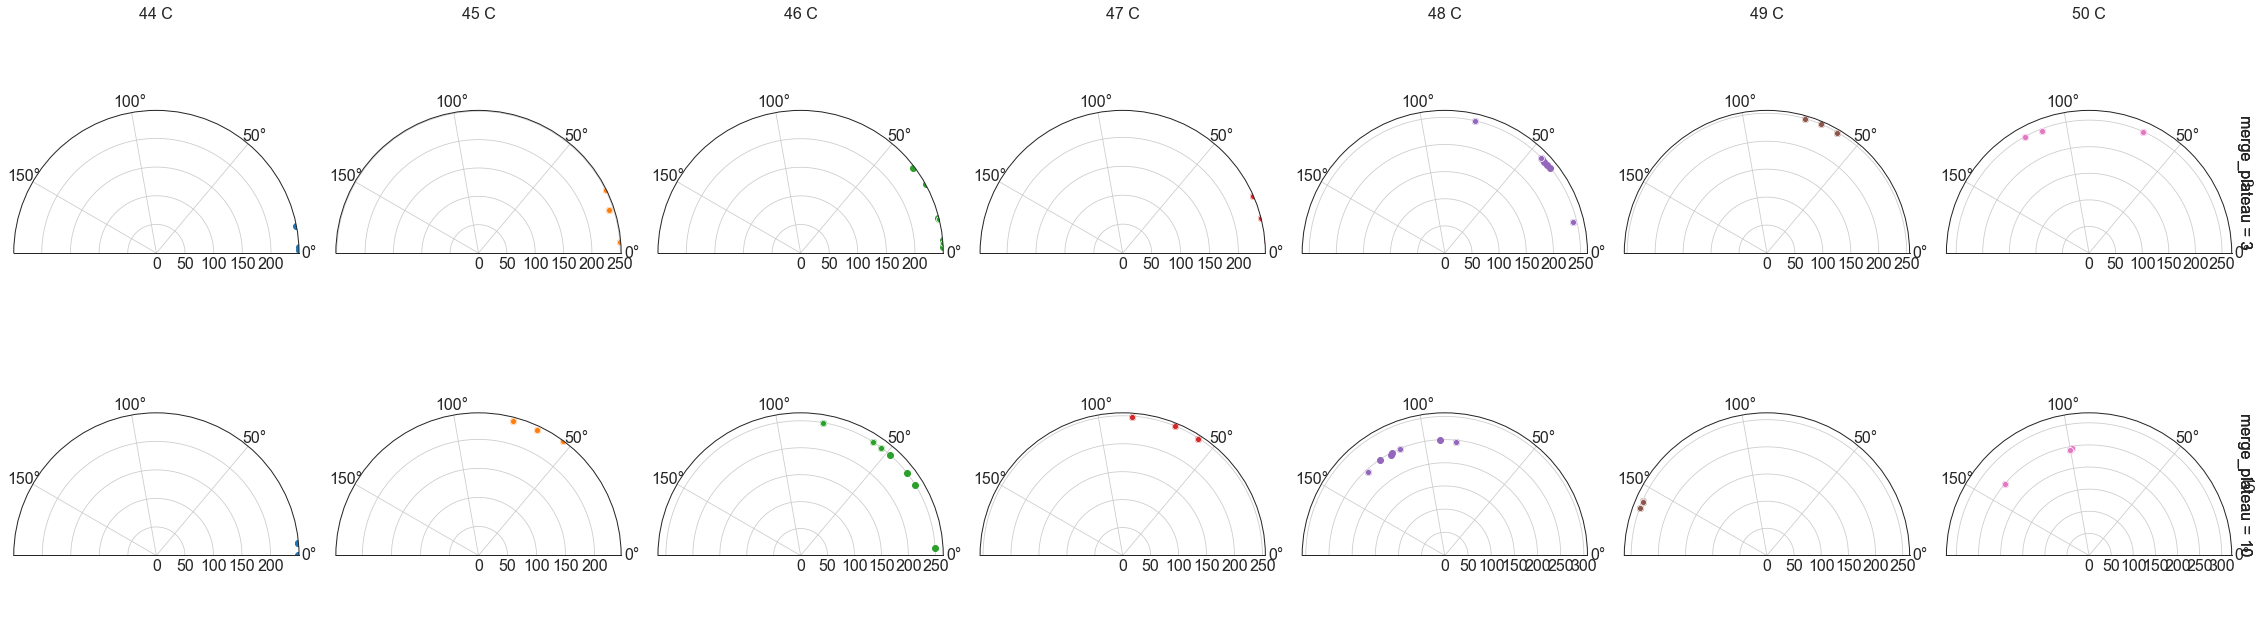

In [32]:
#df = pd.melt(p_result, id_vars=['plateau', 'temperature'], var_name='actual_theta_pi', value_name='actual_theta_pi')
def annotate(data, **kws):
    n = len(data)
    ax = plt.gca()
    ax.set_thetamin(0);ax.set_thetamax(180)

    #ax.text(.1, .6, f"N = {n}", transform=ax.transAxes)

g = sns.FacetGrid(p_result, col="temperature", row = "merge_plateau", hue="temperature",
                  subplot_kws=dict(projection='polar'), size=4.5, #col_wrap=5,
                  sharex=False, sharey=False, despine=False, margin_titles=True)

# Draw a scatterplot onto each axes in the grid
g.map(plt.scatter, "actual_theta_pi", "actual_r")
# g.map.set_thetamin(0);g.map.set_thetamax(180)
g.map_dataframe(sns.scatterplot, x="actual_theta_pi", y="actual_r")
# g.set_axis_labels("theta", "Tip")
g.set_axis_labels("Total bill", "Tip")
g.map_dataframe(annotate)
g.set_titles(col_template="{col_name} C", row_template="{row_name}")
#g.set(xlim=(0, 60), ylim=(0, 12), xticks=[10, 30, 50], yticks=[2, 6, 10])
# plt.savefig('./image.png')

plt.show()


In [ ]:
# just temp per plateau

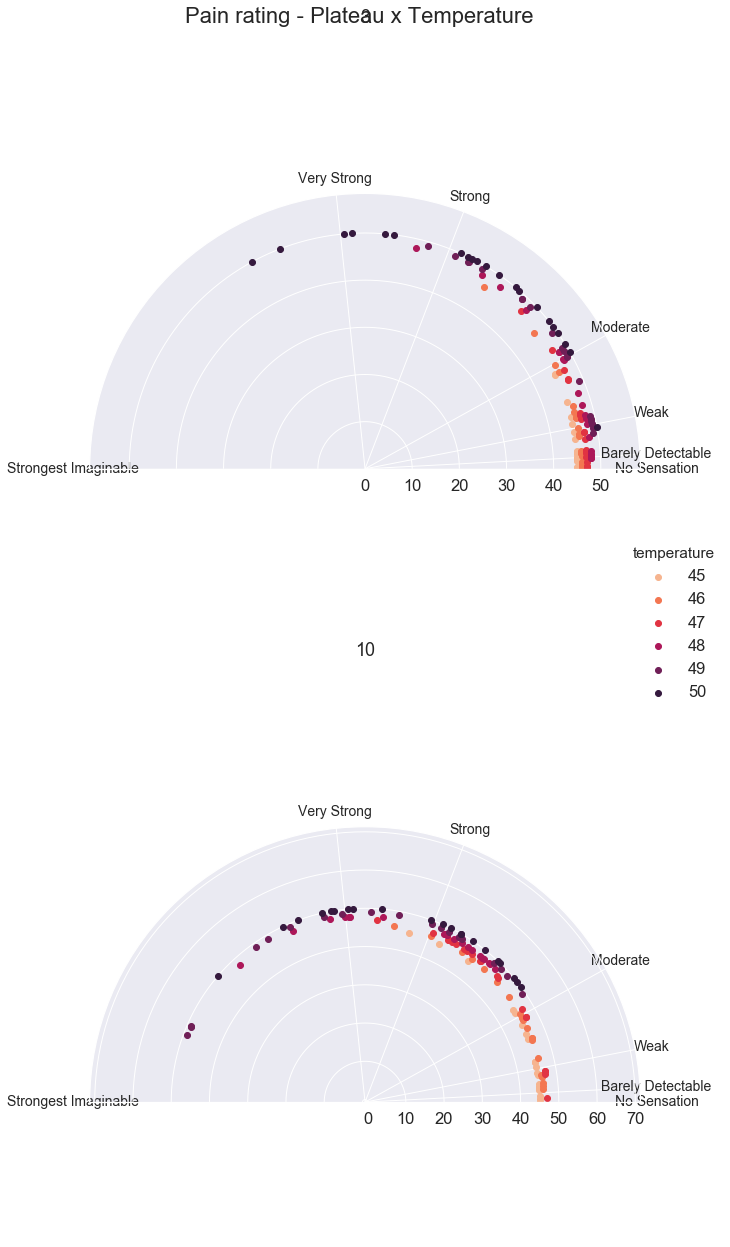

In [183]:
#df = pd.melt(p_result, id_vars=['plateau', 'temperature'], var_name='actual_theta_pi', value_name='actual_theta_pi')
def annotate(data, **kws):
    n = len(data)
    ax = plt.gca()
    ax.set_thetamin(0);ax.set_thetamax(180)
    my_list = [ 0, 3,  11, 29,69, 96, 180]
    my_new_list = [i * np.pi/180 for i in my_list]
    ax.set_xticks(my_new_list)

    ax.set_xticklabels(['No Sensation', 
                        'Barely Detectable', 'Weak', 
                        'Moderate', 'Strong', 'Very Strong', 
                        'Strongest Imaginable'], Fontsize = 14)
g = sns.FacetGrid(p_result,  row = "merge_plateau", hue="temperature", palette = "rocket_r", #hue_kws=d,          
                  subplot_kws=dict(projection='polar'), size=9,  legend_out=True, #col_wrap=5,
                  sharex=False, sharey=False, despine=False) #, margin_titles=True)
g.map(plt.scatter, "actual_theta_pi", "temperature")
g.map_dataframe(annotate)
g.set_titles(row_template="{row_name}")
g.add_legend()
g.fig.suptitle('Pain rating - Plateau x Temperature')
g.fig.tight_layout()
plt.show()


# thermode size x head

/Users/h/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


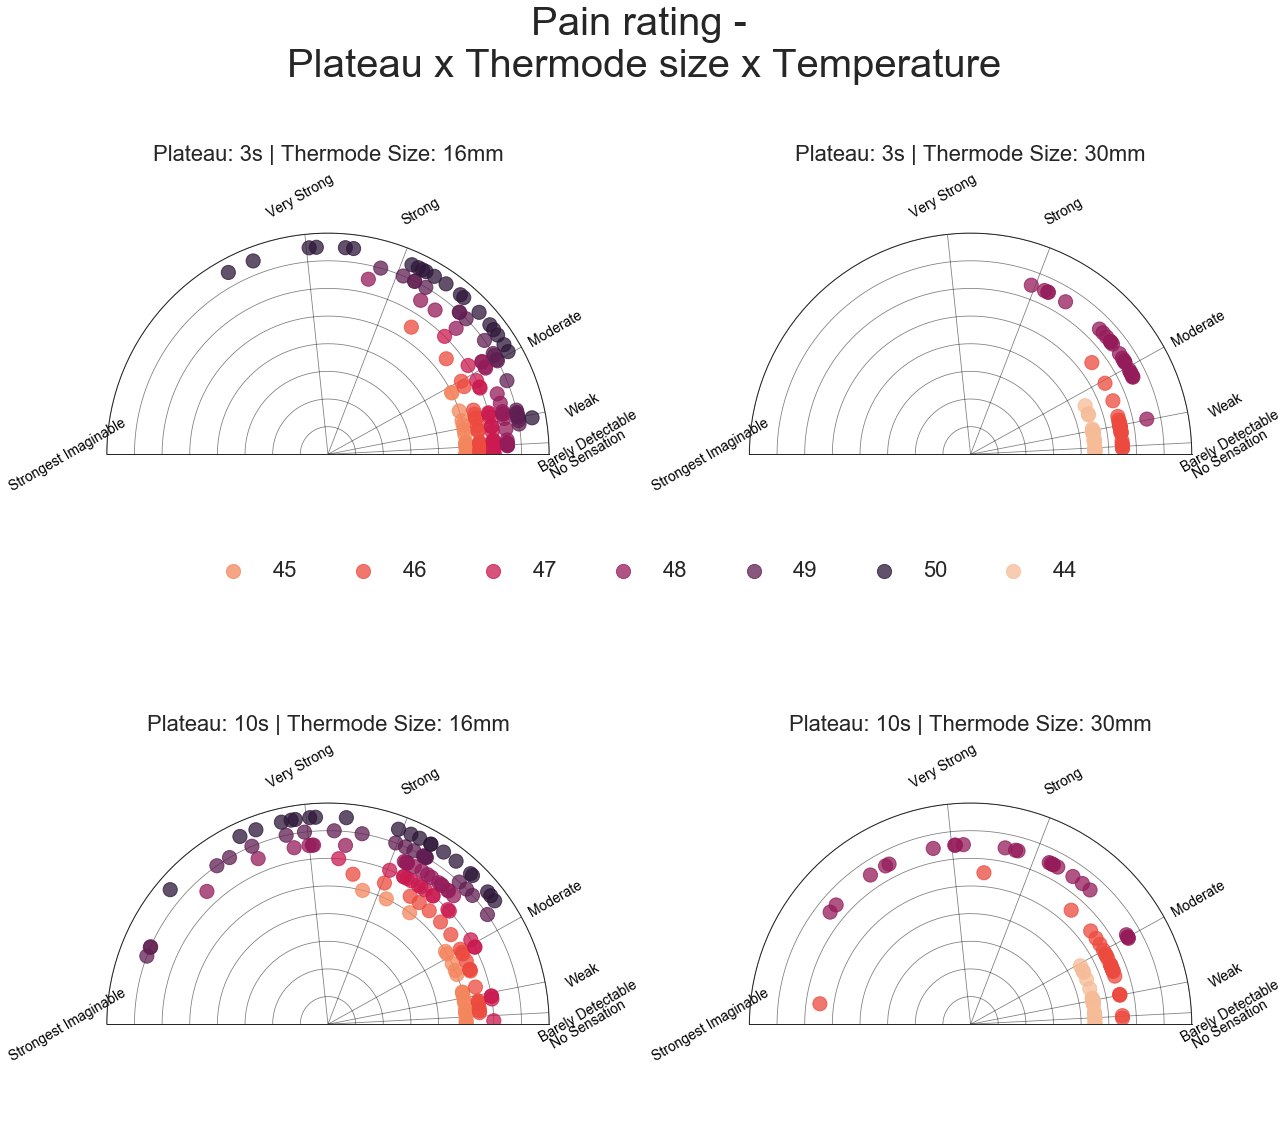

In [12]:
#df = pd.melt(p_result, id_vars=['plateau', 'temperature'], var_name='actual_theta_pi', value_name='actual_theta_pi')
def annotate(data, **kws):
    n = len(data)
    ax = plt.gca()
    ax.set(xmargin=0.05, ymargin=0.15)
    ax.set_thetamin(0);ax.set_thetamax(180)
    my_list = [ 0, 3,  11, 29,69, 96, 180]
    my_new_list = [i * np.pi/180 for i in my_list]
    ax.set_xticks(my_new_list)
    ax.tick_params(direction='out', length=20, width=2, colors='k', pad = 12,
               grid_color='k', grid_alpha=0.5, labelrotation = 30, labelbottom = True)
   
    ax.set_xticklabels(['No Sensation', 
                        'Barely Detectable', 'Weak', 
                        'Moderate', 'Strong', 'Very Strong', 
                        'Strongest Imaginable'])
    ax.title.set_position([.5, 0.9])

    
p_result['newr'] = np.ones(c_result.actual_r.shape)
area = 200 * p_result['newr']**2
p_result.newr = p_result.temperature.replace({44: 0.9, 45: 1, 46:1.1, 47:1.2, 48:1.3, 49:1.4, 50:1.5})
orders = [44,45,46,47,48,49,50]

g = sns.FacetGrid(p_result,  row = "merge_plateau", col = "thermode_size",hue="temperature", palette = "rocket_r", #hue_kws=d,          
                  subplot_kws=dict(projection='polar'), size=9,#hue_order=orders,
                  sharex=False, sharey=False, despine=False)#, margin_titles=True)


g.map(plt.scatter, "actual_theta_pi", "newr", s = area, alpha = 0.75)

    
g.map_dataframe(annotate)

g.set(ylim=(0, 1.6))
g.set(ylabel = None)
g.set(yticklabels=[]) 


g.set_titles(row_template="Plateau: {row_name}s", col_template="Thermode Size: {col_name}mm")

handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='center', ncol=7)
# handles, labels = plt.gca().get_legend_handles_labels()
# order = [7,1,2,3,4,5,6]
# g.fig.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='center', ncol=7)

# handles, labels = g.fig.get_axes().get_legend_handles_labels()
# g.fig.legend(handles=handles, labels=labels, loc='center', ncol=7)
# g.fig.subplots_adjust(top=0.90, bottom=0.10)
# for ax in g.axes.flat:
#     leg = g.axes.flat[0].get_legend()
#     if not leg is None: break
# if leg is None: leg = g._legend
# new_labels = ['44', '45', '46','47', '48', '49', '50']
# for t, l in zip(leg.texts, new_labels): t.set_text(l)

g.fig.suptitle('Pain rating - \nPlateau x Thermode size x Temperature')
g.fig.tight_layout()
plt.show()


In [ ]:
# participant average

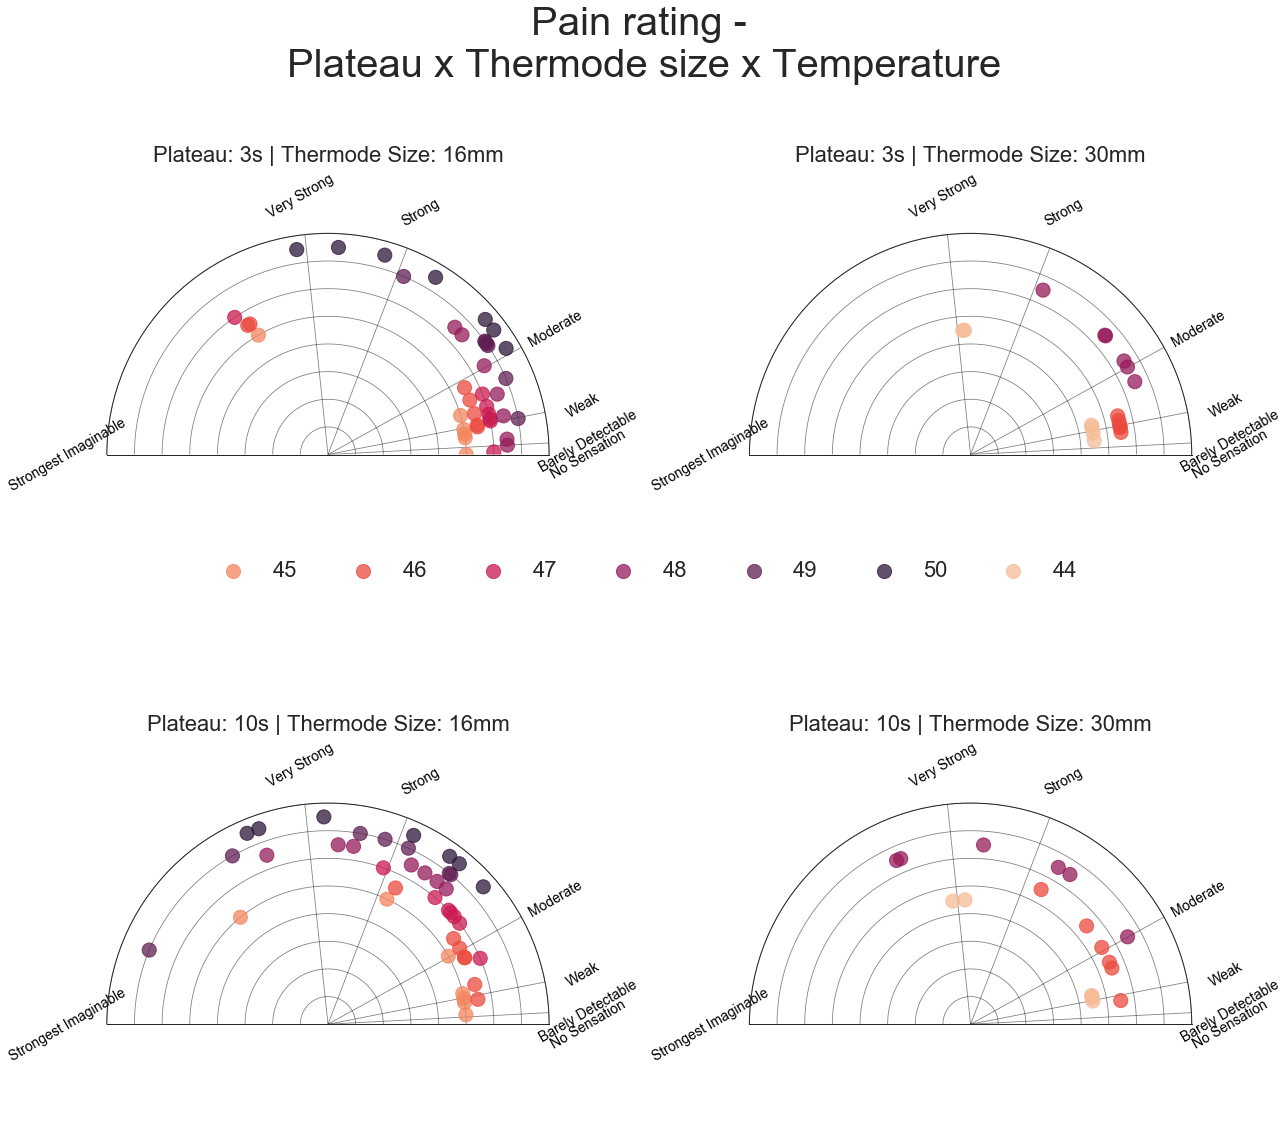

In [15]:
#df = pd.melt(p_result, id_vars=['plateau', 'temperature'], var_name='actual_theta_pi', value_name='actual_theta_pi')
def annotate(data, **kws):
    n = len(data)
    ax = plt.gca()
    ax.set(xmargin=0.05, ymargin=0.15)
    ax.set_thetamin(0);ax.set_thetamax(180)
    my_list = [ 0, 3,  11, 29,69, 96, 180]
    my_new_list = [i * np.pi/180 for i in my_list]
    ax.set_xticks(my_new_list)
    ax.tick_params(direction='out', length=20, width=2, colors='k', pad = 12,
               grid_color='k', grid_alpha=0.5, labelrotation = 30, labelbottom = True)
   
    ax.set_xticklabels(['No Sensation', 
                        'Barely Detectable', 'Weak', 
                        'Moderate', 'Strong', 'Very Strong', 
                        'Strongest Imaginable'])
    ax.title.set_position([.5, 0.9])

c_group_mean = c_rep_resultsult.groupby(['merge_plateau','temperature','thermode_size','src_subject_id']).mean().reset_index()

c_group_mean['newr'] = np.ones(c_group_mean.actual_r.shape)
area = 200 * c_group_mean['newr']**2
c_group_mean.newr = c_group_mean.temperature.replace({44: 0.9, 45: 1, 46:1.1, 47:1.2, 48:1.3, 49:1.4, 50:1.5})
orders = [44,45,46,47,48,49,50]

g = sns.FacetGrid(c_group_mean,  row = "merge_plateau", col = "thermode_size",hue="temperature", palette = "rocket_r", #hue_kws=d,          
                  subplot_kws=dict(projection='polar'), size=9,#hue_order=orders,
                  sharex=False, sharey=False, despine=False)#, margin_titles=True)


g.map(plt.scatter, "actual_theta_pi", "newr", s = area, alpha = 0.75)

    
g.map_dataframe(annotate)

g.set(ylim=(0, 1.6))
g.set(ylabel = None)
g.set(yticklabels=[]) 


g.set_titles(row_template="Plateau: {row_name}s", col_template="Thermode Size: {col_name}mm")

handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='center', ncol=7)
# handles, labels = plt.gca().get_legend_handles_labels()
# order = [7,1,2,3,4,5,6]
# g.fig.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='center', ncol=7)

# handles, labels = g.fig.get_axes().get_legend_handles_labels()
# g.fig.legend(handles=handles, labels=labels, loc='center', ncol=7)
# g.fig.subplots_adjust(top=0.90, bottom=0.10)
# for ax in g.axes.flat:
#     leg = g.axes.flat[0].get_legend()
#     if not leg is None: break
# if leg is None: leg = g._legend
# new_labels = ['44', '45', '46','47', '48', '49', '50']
# for t, l in zip(leg.texts, new_labels): t.set_text(l)

g.fig.suptitle('Pain rating - \nPlateau x Thermode size x Temperature')
g.fig.tight_layout()
plt.show()


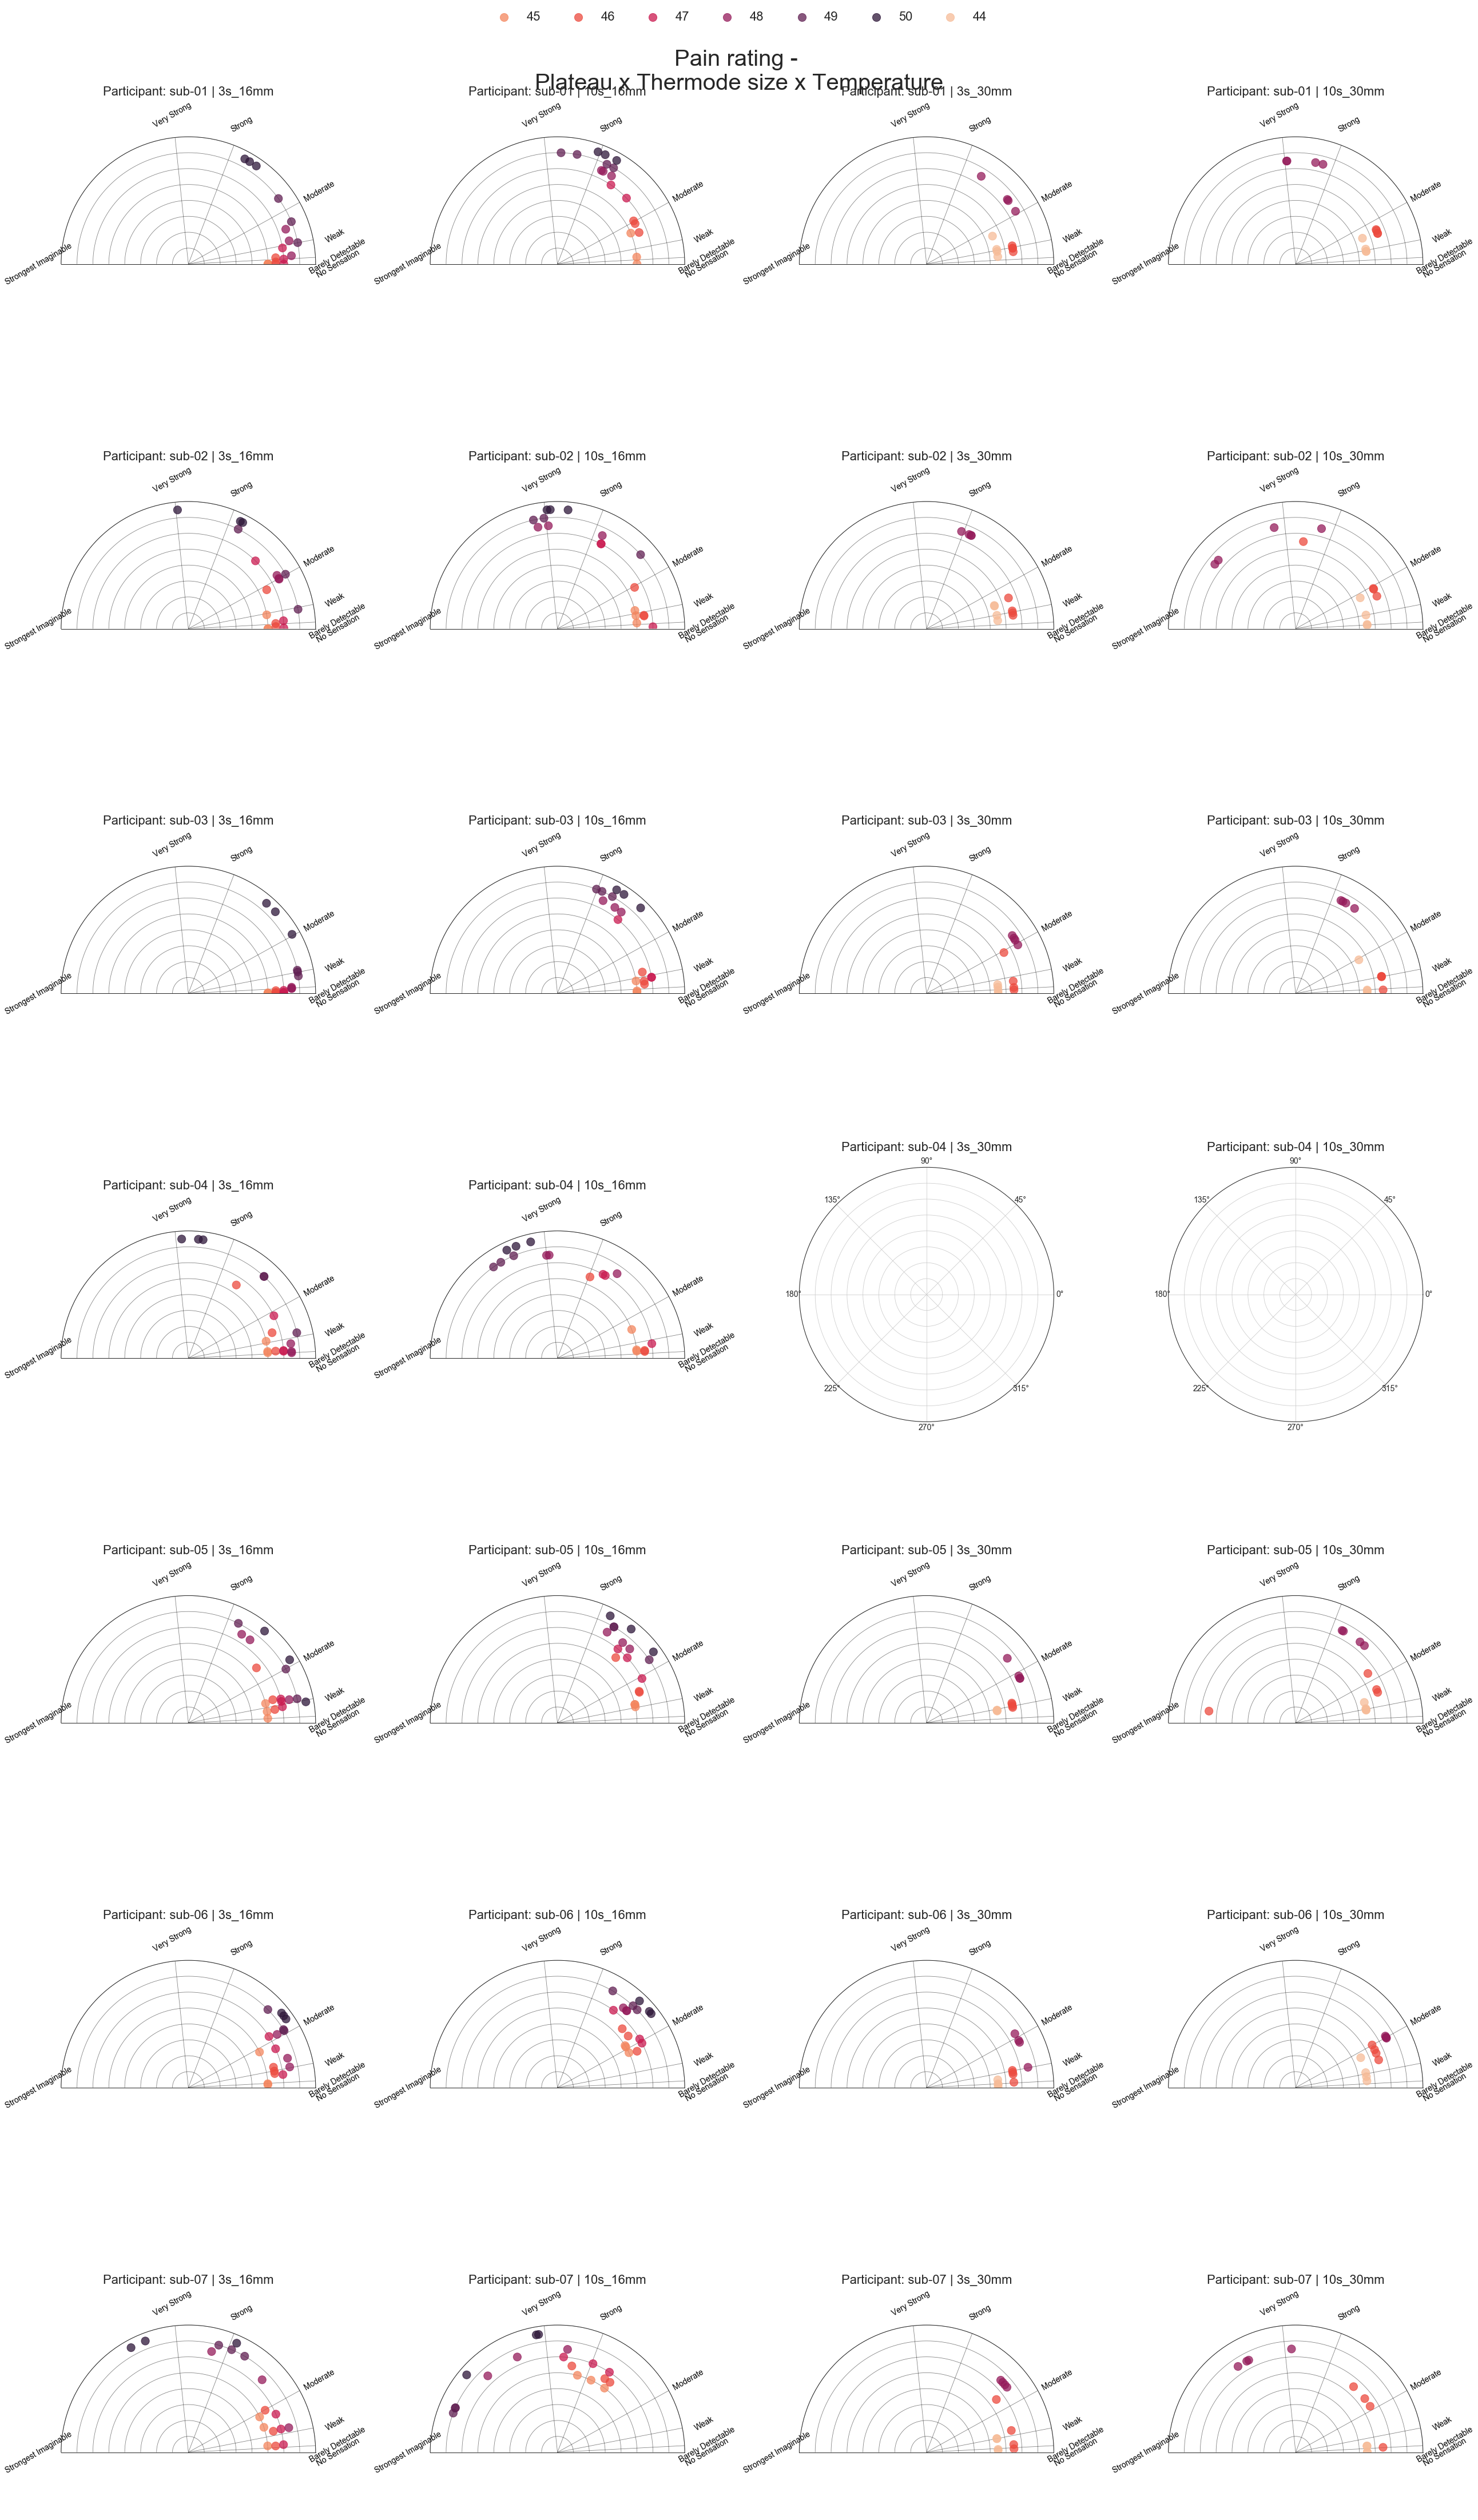

In [44]:
#df = pd.melt(p_result, id_vars=['plateau', 'temperature'], var_name='actual_theta_pi', value_name='actual_theta_pi')
def annotate(data, **kws):
    n = len(data)
    ax = plt.gca()
    ax.set(xmargin=0.05, ymargin=0.15)
    ax.set_thetamin(0);ax.set_thetamax(180)
    my_list = [ 0, 3,  11, 29,69, 96, 180]
    my_new_list = [i * np.pi/180 for i in my_list]
    ax.set_xticks(my_new_list)
    ax.tick_params(direction='out', length=20, width=2, colors='k', pad = 12,
               grid_color='k', grid_alpha=0.5, labelrotation = 30, labelbottom = True)
   
    ax.set_xticklabels(['No Sensation', 
                        'Barely Detectable', 'Weak', 
                        'Moderate', 'Strong', 'Very Strong', 
                        'Strongest Imaginable'])
    ax.title.set_position([.5, 0.9])

cols = ["merge_plateau", "thermode_size"]
c_result['plateau_size']=c_result['merge_plateau'].astype(str)+'s_'+ c_result['thermode_size'].astype(str) + 'mm'

c_result['newr'] = np.ones(c_result.actual_r.shape)
area = 200 * c_result['newr']**2
c_result.newr = c_result.temperature.replace({44: 0.9, 45: 1, 46:1.1, 47:1.2, 48:1.3, 49:1.4, 50:1.5})
orders = [44,45,46,47,48,49,50]



g = sns.FacetGrid(c_result,  row =  "src_subject_id", col = "plateau_size",hue="temperature", palette = "rocket_r", #hue_kws=d,          
                  subplot_kws=dict(projection='polar'), size=9,#hue_order=orders,
                  sharex=False, sharey=False, despine=False)#, margin_titles=True)


g.map(plt.scatter, "actual_theta_pi", "newr", s = area, alpha = 0.75)

    
g.map_dataframe(annotate)

g.set(ylim=(0, 1.6))
g.set(ylabel = None)
g.set(yticklabels=[]) 


g.set_titles(row_template="Participant: sub-0{row_name}", col_template="{col_name}")

handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=7)


g.fig.suptitle('Pain rating - \nPlateau x Thermode size x Temperature')
g.fig.tight_layout()
plt.show()


In [39]:
# p_result['plateau_size'] = str(str(c_result["merge_plateau"]) +"s "+ str(c_result["thermode_size"]) +"mm")

cols = ["merge_plateau", "thermode_size"]
p_result['plateau_size']=p_result['merge_plateau'].astype(str)+'s_'+ p_result['thermode_size'].astype(str) + 'mm'
# p_result['plateau_size'] = c_result[cols].apply(lambda row: 's_'.join(row.values.astype(str)), axis=1)

In [41]:
p_result

Unnamed: 0  actual_ptb_coord_x  actual_ptb_coord_y  administer  \
0            0                 741                 587         147   
1            1                 999                 463          38   
2            2                 782                 532         149   
3            3                 863                 477         150   
4            4                1003                 469          38   
5            5                 730                 631         146   
6            6                 859                 490          33   
7            7                 736                 596         146   
8            8                1049                 477         151   
9            9                 904                 464         149   
10          10                1057                 477          36   
11          11                 900                 475          33   
12          12                1080                 488         151   
13          13                 711                 689         147   
14          14                 711                 687         146   
15          15                1189                 607          37   
16          16                 825                 497          34   
17          17                 825                 499          35   
18          18                 718                 647         147   
19          19                1194                 619          37   
20          20                 867                 475          35   
21          21                 735                 609         148   
22          22                 810                 507          34   
23          23                 815                 509          33   
24          24                 859                 479         151   
25          25                 892                 467         150   
26          26                 834                 492         150   
27          27                1150                 545          38   
28          28                 919                 461          34   
29          29                 721                 647         148   
..         ...                 ...                 ...         ...   
6            6                 729                 666         146   
7            7                 982                 458          38   
8            8                 756                 584         149   
9            9                 764                 598         149   
10          10                 982                 458          36   
11          11                 757                 593         150   
12          12                 975                 458          38   
13          13                 719                 707         146   
14          14                 723                 701         147   
15          15                 848                 490          35   
16          16                 712                 707         146   
17          17                 851                 489         150   
18          18                1007                 462          36   
19          19                 711                 686         148   
20          20                 848                 488          35   
21          21                 720                 667          33   
22          22                 712                 692         147   
23          23                 712                 705         148   
24          24                 939                 471          38   
25          25                1014                 463          37   
26          26                 723                 702          35   
27          27                 785                 551          37   
28          28                 723                 665         150   
29          29                 989                 470          37   
30          30                 729                 671          34   
31          31

In [ ]:
### tips
https://seaborn.pydata.org/generated/seaborn.FacetGrid.html
    https://kitware.github.io/seaborn_altair/facetgrid.html
https://stackoverflow.com/questions/16085397/changing-labels-in-matplotlib-polar-plot
https://stackoverflow.com/questions/14845350/multiple-x-axis-which-are-nonlinear-to-each-other
    https://seaborn.pydata.org/examples/facet_projections.html
        https://seaborn.pydata.org/generated/seaborn.FacetGrid.html
            https://towardsdatascience.com/seaborn-facetgrid-taking-subplots-further-15ee7af54e44

# load cognitive

In [70]:
sublist = [3,4] 
thermode = ['cognitive'] #, 30]
main_dir = '/Users/h/Documents/projects_local/social_influence_analysis/dartmouth/beh_withcoord'

df = pd.DataFrame()
c_result = pd.DataFrame()

for ind,sub in enumerate(sublist):
    loadfilename =  glob.glob(os.path.join(main_dir ,  'sub-*', 
                                  '*_task-cognitive_meta_beh.csv'))
for file in loadfilename:
    df = pd.read_csv(file)
#     df['src_subject_id'] = sub
    c_result = pd.concat([c_result, df], axis = 0, sort = True)

In [71]:
# step 3 - subtract mid point (psychtoolbox) ________________________________________________________________________

c_result['new_actual_coord_x'] = (c_result['actual_ptb_coord_x'] - origin_x)
c_result['new_actual_coord_y'] = (c_result['actual_ptb_coord_y'] - origin_y)

c_result['actual_r'], c_result['actual_theta'] = cart2pol(c_result['new_actual_coord_x'], c_result['new_actual_coord_y'])
c_result['actual_theta_pi'] = c_result['actual_theta']-np.pi
c_result['actual_theta_degree'] = c_result['actual_theta_pi']*180/np.pi


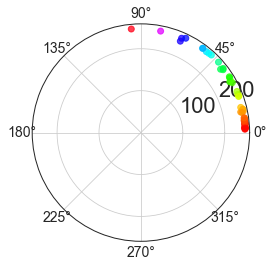

In [72]:
c_actual_filter = c_result.loc[(c_result['actual_r']>=150) & (c_result['event04_actual_responseonset'] != "NA") ]
# Compute areas and colors
c_result = c_actual_filter
colors = c_result['actual_theta_pi']

fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(c_result['actual_theta_pi'], c_result['actual_r'], c=colors, cmap='hsv', alpha=0.75)


## cognitive - actual rating - cue

Text(0.5, 0.8, 'Thermode ratings\n on a semi-circular scale')

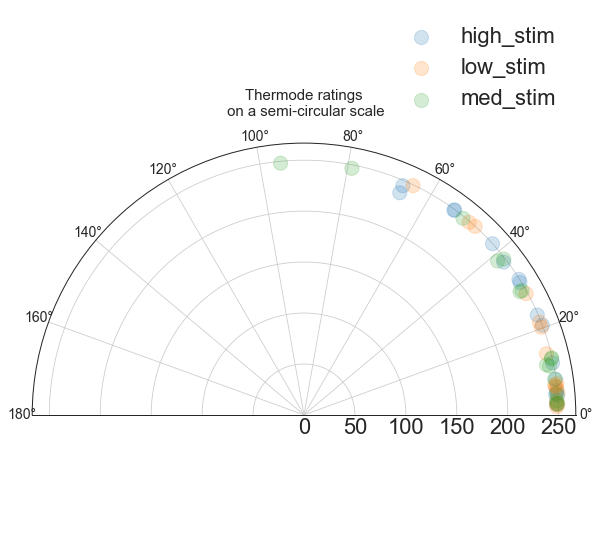

In [73]:


# area = 200 * result['expect_newr']**2
c_result['newr'] = np.ones(c_result.actual_r.shape)
area = 200 * c_result['newr']**2
groups = c_result.groupby('param_stimulus_type')
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='polar')
ax.set_thetamin(0)
ax.set_thetamax(180)

for name, group in groups:
    ax.scatter(group.actual_theta_pi, group.actual_r,label=name, alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
ax.legend()

figure_title = "Thermode ratings\n on a semi-circular scale"
plt.text(0.5, 0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

### plot by rotation degrees

Text(0.5, 0.8, 'Pain task\n rating on semi-circular scale per degree')

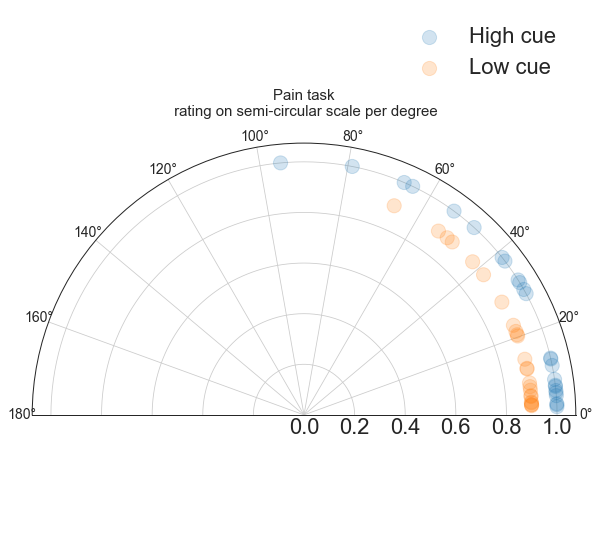

In [74]:
# Compute areas and colors

colors = c_result['actual_theta_pi']
c_result['newr'] = np.ones(c_result.actual_r.shape)

area = 200 * c_result['newr']**2


ca_group_low = c_result.loc[c_result['param_cue_type'] =='low_cue']
ca_group_high = c_result.loc[(c_result['param_cue_type']== 'high_cue')] #| (p_result['param_cue_type']== 10)]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='polar')
ax.set_thetamin(0)
ax.set_thetamax(180)
p100 = ax.scatter(ca_group_high.actual_theta_pi, np.ones(ca_group_high.actual_r.shape),label='High cue', alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
p50 = ax.scatter(ca_group_low.actual_theta_pi, np.ones(ca_group_low.actual_r.shape)*0.9,label='Low cue', alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
figure_title = "Pain task\n rating on semi-circular scale per degree"
plt.text(0.5, 0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

# participant mean

In [75]:
c_group_mean.loc[c_group_mean['param_cue_type'] =='low_cue']

param_cue_type  src_subject_id  ISI01_biopac  ISI01_duration   ISI01_onset  \
2        low_cue               3  1.611771e+09        1.544243  1.611771e+09   
3        low_cue               4  1.611760e+09        1.504346  1.611760e+09   

   ISI02_biopac  ISI02_duration   ISI02_onset  ISI03_biopac  ISI03_duration  \
2  1.611771e+09        4.712972  1.611771e+09  1.611771e+09        3.646683   
3  1.611760e+09        4.110595  1.611760e+09  1.611760e+09        3.130650   

   ...  param_start_biopac  param_trigger_onset  session_id  \
2  ...        1.611771e+09         1.611771e+09         1.0   
3  ...        1.611760e+09         1.611760e+09         1.0   

   new_actual_coord_x  new_actual_coord_y    actual_r  actual_theta  \
2         -121.416667         -192.583333  246.552977     -2.135355   
3         -243.500000          -34.583333  248.273563     -2.999485   

   actual_theta_pi  actual_theta_degree  newr  
2        -5.276948          -302.346827   1.0  
3        -6.141078          -351.857841   1.0  

[2 rows x 65 columns]

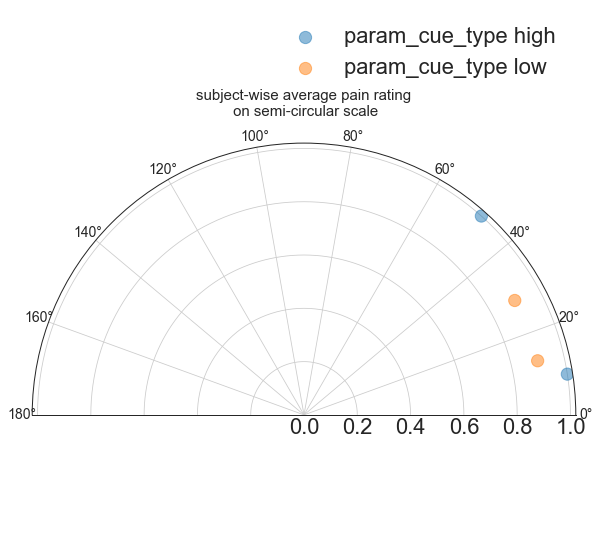

In [76]:
c_group_mean = c_result.groupby(['param_cue_type','src_subject_id']).mean().reset_index()
colors = c_group_mean['actual_theta_pi']
c_group_mean['newr'] = np.ones(c_group_mean.actual_r.shape)
area = 150 * c_group_mean['newr']**2

c_group_mean_low = c_group_mean.loc[c_group_mean['param_cue_type'] =='low_cue']
c_group_mean_high = c_group_mean.loc[(c_group_mean['param_cue_type']== 'high_cue')] 
fig = plt.figure(figsize=(10, 10));ax = fig.add_subplot(projection='polar');ax.set_thetamin(0);ax.set_thetamax(180)
figure_title = "subject-wise average pain rating\n on semi-circular scale"
plt.text(0.5,0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

chigh = ax.scatter(c_group_mean_high.actual_theta_pi, np.ones(c_group_mean_high.newr.shape),label='param_cue_type high', alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
clow = ax.scatter(c_group_mean_low.actual_theta_pi, np.ones(c_group_mean_low.newr.shape)*0.9,label='param_cue_type low', alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 

# p150 = ax.scatter(group_mean_150.theta, np.ones(group_mean_150.newr.shape)*1.1,label=150, alpha=0.60, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
ax.legend()

## cognitive - actual rating - stim

### plot raw form

Text(0.5, 0.8, 'Cognitive task\n rating on semi-circular scale')

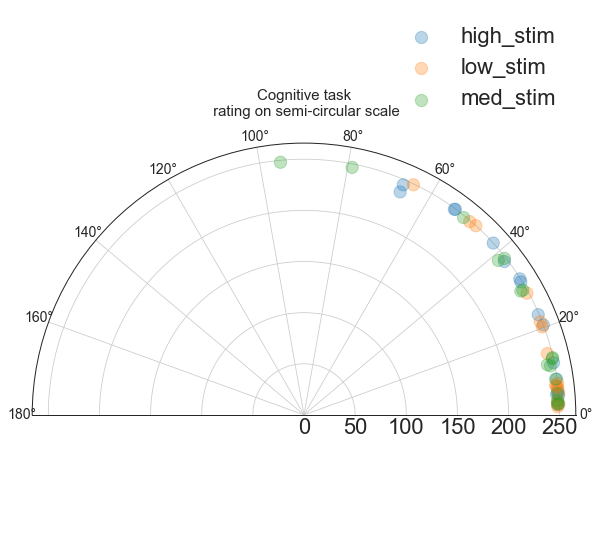

In [77]:
groups = c_result.groupby('param_stimulus_type')
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='polar')
ax.set_thetamin(0)
ax.set_thetamax(180)

for name, group in groups:
    ax.scatter(group.actual_theta_pi, group.actual_r,label=name, alpha=0.30, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
ax.legend()

figure_title = "Cognitive task\n rating on semi-circular scale"
plt.text(0.5, 0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

### plot by degrees

Text(0.5, 0.8, "all subject's rating on semi-circular scale per celcius")

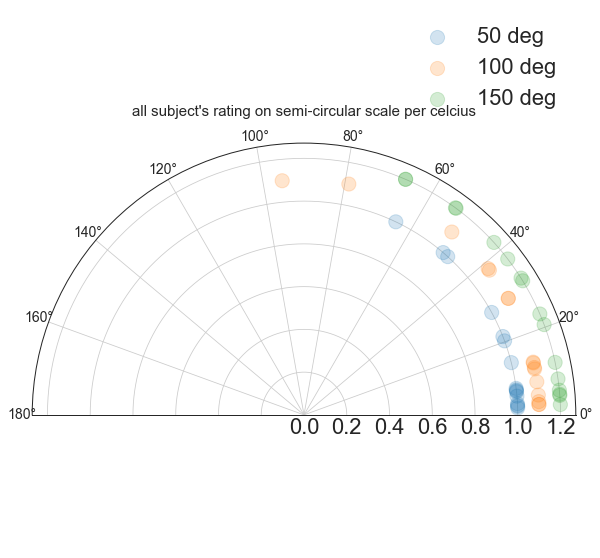

In [83]:
# Compute areas and colors
colors = c_result['actual_theta_pi']
c_result['newr'] = np.ones(c_result.actual_r.shape)

area = 200 * c_result['newr']**2

# groups = c_result.groupby('administer')
group45 = c_result[c_result['param_stimulus_type'] =='low_stim']
group46 = c_result[c_result['param_stimulus_type'] =='med_stim']
group47 = c_result[c_result['param_stimulus_type'] =='high_stim']


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='polar')
ax.set_thetamin(0)
ax.set_thetamax(180)
p45 = ax.scatter(group45.actual_theta_pi, np.ones(group45.actual_r.shape)*1.0,label='50 deg', alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
p46 = ax.scatter(group46.actual_theta_pi, np.ones(group46.actual_r.shape)*1.1,label='100 deg', alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
p47 = ax.scatter(group47.actual_theta_pi, np.ones(group47.actual_r.shape)*1.2,label='150 deg', alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
# p48 = ax.scatter(group48.actual_theta_pi, np.ones(group48.actual_r.shape)*1.3,label=48, alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
# p49 = ax.scatter(group49.actual_theta_pi, np.ones(group49.actual_r.shape)*1.4,label=49, alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
# p50 = ax.scatter(group50.actual_theta_pi, np.ones(group50.actual_r.shape)*1.5,label=50, alpha=0.20, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
figure_title = "all subject's rating on semi-circular scale per celcius"
plt.text(0.5, 0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

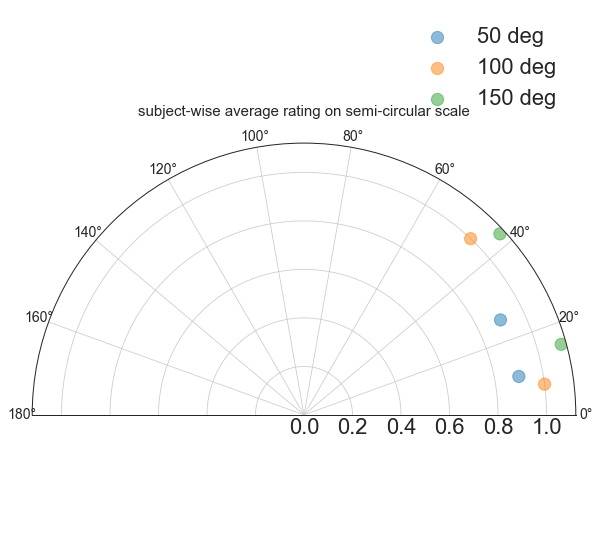

In [85]:
c_group_mean = c_result.groupby(['param_stimulus_type','src_subject_id']).mean().reset_index()
colors = c_group_mean['actual_theta_pi']
c_group_mean['newr'] = np.ones(c_group_mean.actual_r.shape)
# area = 200 * p_result['newr']**2
area = 150 * c_group_mean['newr']**2


# actual_group_mean_50 = c_group_mean[c_group_mean['p5_administer_type'] ==50]
# actual_group_mean_100 = c_group_mean[c_group_mean['p5_administer_type'] ==100]
# actual_group_mean_150 = c_group_mean[c_group_mean['p5_administer_type'] ==150]


group_mean_45 = c_group_mean[c_group_mean['param_stimulus_type'] =='low_stim']
group_mean_46 = c_group_mean[c_group_mean['param_stimulus_type'] =='med_stim']
group_mean_47 = c_group_mean[c_group_mean['param_stimulus_type'] =='high_stim']


fig = plt.figure(figsize=(10, 10));ax = fig.add_subplot(projection='polar');
ax.set_thetamin(0);ax.set_thetamax(180)

figure_title = "subject-wise average rating on semi-circular scale"
plt.text(0.5,0.8, figure_title,
         horizontalalignment='center',
         fontsize=15,
         transform = ax.transAxes)

mp45 = ax.scatter(group_mean_45.actual_theta_pi, np.ones(group_mean_45.newr.shape)*0.9,label='50 deg', alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
mp46 = ax.scatter(group_mean_46.actual_theta_pi, np.ones(group_mean_46.newr.shape)*1.0,label='100 deg', alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
mp47 = ax.scatter(group_mean_47.actual_theta_pi, np.ones(group_mean_47.newr.shape)*1.1,label='150 deg', alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
# mp48 = ax.scatter(group_mean_48.actual_theta_pi, np.ones(group_mean_48.newr.shape)*1.2,label=50, alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
# mp49 = ax.scatter(group_mean_49.actual_theta_pi, np.ones(group_mean_49.newr.shape)*1.3,label=50, alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 
# mp50 = ax.scatter(group_mean_50.actual_theta_pi, np.ones(group_mean_50.newr.shape)*1.4,label=50, alpha=0.50, s=area, marker='o',cmap='hsv') # c=colors, s=area, cmap='hsv', 

ax.legend()